In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd




In [2]:
!unzip /kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip


Archive:  /kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip
  inflating: test.csv                


In [3]:
!unzip /kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip

Archive:  /kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
  inflating: train.csv               


In [4]:
physical_devices = tf.config.list_physical_devices('GPU')

In [5]:
data = pd.read_csv('/kaggle/working/train.csv')

In [6]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
data.count(axis=1,level=None,numeric_only=True)

0         6
1         6
2         6
3         6
4         6
         ..
159566    6
159567    6
159568    6
159569    6
159570    6
Length: 159571, dtype: int64

In [8]:
x=data['toxic'].value_counts()[0]
x


144277

In [9]:
y=data['toxic'].value_counts()[1]
y


15294

In [10]:
x = data['comment_text']
x

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: comment_text, Length: 159571, dtype: object

### 

preprosseing


In [11]:
from tensorflow.keras.layers import TextVectorization 

In [12]:
X=data['comment_text']
Y=data[data.columns[2:]]



In [13]:
MAX_FETURES=200000

In [14]:
vecterizor = TextVectorization(max_tokens=MAX_FETURES,output_sequence_length=1800,output_mode='int')

In [15]:
type(X)


pandas.core.series.Series

In [16]:
type(X.values)

numpy.ndarray

In [17]:
vecterizor.adapt(X.values)

In [18]:
vectorized_text=vecterizor(X.values)

In [19]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [20]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, Y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [21]:
dataset.as_numpy_iterator().next()
(batch_x,batch_y)=dataset.as_numpy_iterator().next()

In [22]:
batch_x.shape

(16, 1800)

In [23]:
batch_y.shape

(16, 6)

competing the pieline by particining the data set into train test and vald


In [24]:
train=dataset.take(int(len(dataset)*7))
vald=dataset.skip(int(len(dataset)*7)).take(int(len(dataset)*2))
test=dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout,Bidirectional,Embedding

In [26]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FETURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.01))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [27]:
model.compile(loss='BinaryCrossentropy',optimizer='Adam')

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          6400032   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 7

In [29]:
from keras.callbacks import EarlyStopping

In [30]:
es = EarlyStopping(monitor='val_loss',patience = 3, verbose=1,restore_best_weights=True)

In [31]:
history = model.fit(train, epochs=5,validation_data=vald,callbacks=[es])

Epoch 1/5
9974/9974 [==============================] - 1065s 106ms/step - loss: 0.0595
Epoch 2/5
9974/9974 [==============================] - 1063s 107ms/step - loss: 0.0433
Epoch 3/5
9974/9974 [==============================] - 1065s 107ms/step - loss: 0.0365
Epoch 4/5
9974/9974 [==============================] - 1063s 107ms/step - loss: 0.0312
Epoch 5/5
9974/9974 [==============================] - 1062s 106ms/step - loss: 0.0267


In [32]:
model.save('commenttoxicity.h5')

<Figure size 576x144 with 0 Axes>

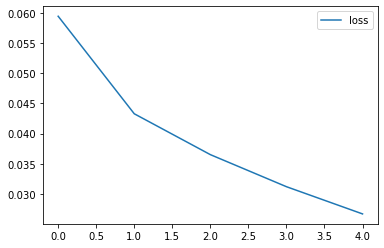

In [33]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,2))
pd.DataFrame(history.history).plot()
plt.show()

predition time

In [34]:
batch=test.as_numpy_iterator().next() 

In [35]:
input_text=vecterizor('You are so horible. I hate you')

In [36]:
input_text

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([ 7, 20, 37, ...,  0,  0,  0])>

In [37]:
np.expand_dims(input_text,0)

array([[ 7, 20, 37, ...,  0,  0,  0]])

In [38]:
model.predict(np.expand_dims(input_text,0))

array([[0.89590955, 0.00436866, 0.04203485, 0.01006283, 0.38152352,
        0.07104596]], dtype=float32)

In [39]:
model.predict(np.expand_dims(input_text,0))

array([[0.89590955, 0.00436866, 0.04203485, 0.01006283, 0.38152352,
        0.07104596]], dtype=float32)

In [40]:
batch_X,batch_Y=test.as_numpy_iterator().next() 

In [41]:
(model.predict(batch_X)>0.5).astype(int)

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [42]:
batch_Y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [43]:
res=model.predict(np.expand_dims(input_text,0))

In [44]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [45]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [46]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

In [47]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8944377899169922, Recall:0.8737949132919312, Accuracy:0.5105316042900085
